In [1]:
# Imports
import os
import seqdata as sd
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eugene import preprocess as pp

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
# TODO: change to your paths
data_dir = "/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP"
fasta = "/cellar/users/aklie/data/ref/genomes/hg38/hg38.fa"
peaks = os.path.join(data_dir, "processed/2023_12_25/encode/U2AF2/U2AF2_gene_peaks_1.minimal.bed")
signals = [os.path.join(data_dir, "processed/2023_12_25/encode/U2AF2_v2/ENCFF913WRH.bigWig"), os.path.join(data_dir, "processed/2023_12_25/encode/U2AF2_v2/ENCFF368XEI.bigWig")]
controls = [os.path.join(data_dir,"processed/2023_12_25/encode/U2AF2_v2/ENCFF989JBA.bigWig"), os.path.join(data_dir, "processed/2023_12_25/encode/U2AF2_v2/ENCFF566CFJ.bigWig")]
bigwigs = signals + controls
sample_names = ['signal+', 'signal-', 'control+', 'control-']
out = '/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/training/2023_12_25/HepG2/U2AF2_test_10.zarr'
bigwigs, sample_names

(['/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/processed/2023_12_25/encode/U2AF2_v2/ENCFF913WRH.bigWig',
  '/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/processed/2023_12_25/encode/U2AF2_v2/ENCFF368XEI.bigWig',
  '/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/processed/2023_12_25/encode/U2AF2_v2/ENCFF989JBA.bigWig',
  '/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/processed/2023_12_25/encode/U2AF2_v2/ENCFF566CFJ.bigWig'],
 ['signal+', 'signal-', 'control+', 'control-'])

In [10]:
# Define training and validation chromosomes
training_chroms = ['chr{}'.format(i) for i in [3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]]
valid_chroms = ["chr1", "chr8", "chr15"]
test_chroms = ["chr2", "chr9", "chr16"]
len(training_chroms), len(valid_chroms), len(test_chroms)

(16, 3, 3)

In [11]:
make_sdata = True

In [13]:
# Compose a SeqData from a set of files - only run this once!
if make_sdata:
sdata = sd.from_region_files(
    sd.GenomeFASTA(
        'seq',
        fasta,
        batch_size=2048,
        n_threads=4,
    ),
    sd.BigWig(
        'cov',
        [bigwigs[0]],
        [sample_names[0]],
        batch_size=2048,
        n_jobs=4,
        threads_per_job=2,
        dtype="float64",
    ),
    path=out,
    fixed_length=2000,
    bed=peaks,
    overwrite=True,
    max_jitter=32
)
    make_sdata = False
else:
    sdata = sd.open_zarr(out)

100%|██████████| 64833/64833 [00:02<00:00, 25847.98it/s]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 64833/64833 [00:15<00:00, 4168.36it/s]


In [14]:
sdata.load()

<xarray.Dataset>
Dimensions:     (_sequence: 64833, cov_sample: 1, _length: 2064)
Coordinates:
  * cov_sample  (cov_sample) object 'signal+'
Dimensions without coordinates: _sequence, _length
Data variables:
    chrom       (_sequence) object 'chr1' 'chr1' 'chr1' ... 'chrM' 'chrM' 'chrM'
    chromEnd    (_sequence) int64 630925 630950 630975 631000 ... 4172 4197 4222
    chromStart  (_sequence) int64 628861 628886 628911 628936 ... 2108 2133 2158
    cov         (_sequence, cov_sample, _length) float64 nan nan nan ... nan nan
    seq         (_sequence, _length) |S1 b'G' b'A' b'T' b'T' ... b'T' b'C' b'T'
    strand      (_sequence) object '+' '+' '+' '+' '+' ... '+' '+' '+' '+' '+'
Attributes:
    length_dim:    _length
    max_jitter:    32
    sequence_dim:  _sequence

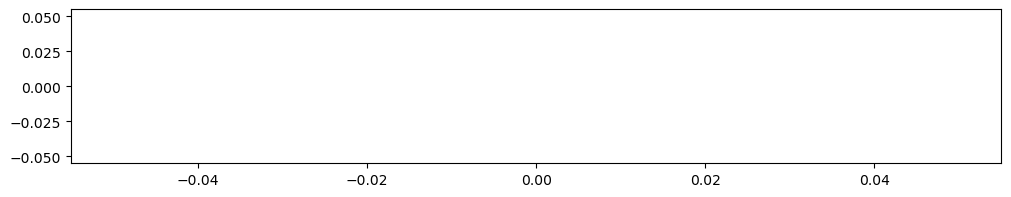

In [12]:
# Plot signal and control
seq_num = 51680
ser = sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
fig, ax = plt.subplots(figsize=(12,2))
plt.plot(sdata["cov"][seq_num][0].values, label="+ signal")

True

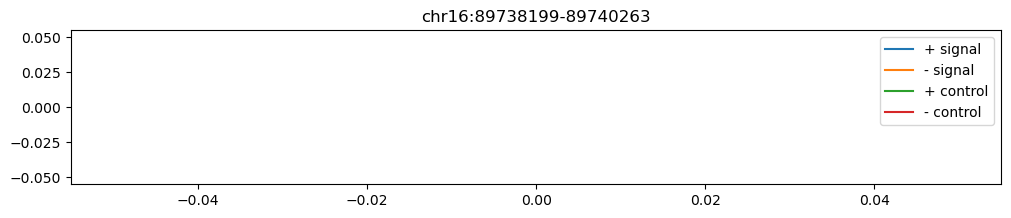

In [172]:
# Plot signal and control
seq_num = 51680
ser = sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
fig, ax = plt.subplots(figsize=(12,2))
plt.plot(sdata["cov"][seq_num][0].values, label="+ signal")
plt.plot(sdata["cov"][seq_num][1].values, label="- signal")
plt.plot(sdata["cov"][seq_num][2].values, label="+ control")
plt.plot(sdata["cov"][seq_num][3].values, label="- control")
plt.title(ser["chrom"] + ":" + ser["chromStart"].astype(str) + "-" + ser["chromEnd"].astype(str))
plt.legend()
np.isnan(sdata["cov"][seq_num].values[0]).all()

In [160]:
# Split cov into control and signal
sdata['control'] = (
    sdata.cov.sel(cov_sample=['control+', 'control-'])
    .rename({'cov_sample': 'cov_strand'})
    .assign_coords({'cov_strand': ['+', '-']})
)
sdata['signal'] = (
    sdata.cov.sel(cov_sample=['signal+', 'signal-'])
    .rename({'cov_sample': 'cov_strand'})
    .assign_coords({'cov_strand': ['+', '-']})
)
sdata = sdata.drop_vars(['cov', 'cov_sample'])
sdata.load()

<xarray.Dataset>
Dimensions:     (_sequence: 64833, _length: 2064, cov_strand: 2)
Coordinates:
  * cov_strand  (cov_strand) <U1 '+' '-'
Dimensions without coordinates: _sequence, _length
Data variables:
    chrom       (_sequence) object 'chr1' 'chr1' 'chr1' ... 'chrM' 'chrM' 'chrM'
    chromEnd    (_sequence) int64 630925 630950 630975 631000 ... 4172 4197 4222
    chromStart  (_sequence) int64 628861 628886 628911 628936 ... 2108 2133 2158
    name        (_sequence) object 'ENSG00000225630.1' ... 'ENSG00000210082.2'
    score       (_sequence) float64 2.0 2.0 2.0 2.0 2.0 ... 3.0 3.0 3.0 3.0 3.0
    seq         (_sequence, _length) |S1 b'G' b'A' b'T' b'T' ... b'T' b'C' b'T'
    strand      (_sequence) object '+' '+' '+' '+' '+' ... '+' '+' '+' '+' '+'
    thickEnd    (_sequence) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    thickStart  (_sequence) int64 20 101 148 77 80 ... 14912 18152 17996 30963
    control     (_sequence, cov_strand, _length) float32 nan nan nan ... nan nan
    signal      (_sequence, cov_strand, _length) float32 nan nan nan ... nan nan
Attributes:
    length_dim:    _length
    max_jitter:    32
    sequence_dim:  _sequence

In [161]:
# Keep only 
sdata = sdata.sel(_sequence=((sdata["chrom"].isin(training_chroms + valid_chroms + test_chroms))))
sdata["chrom"].to_series().value_counts()

chr2     8836
chr1     4830
chr6     4750
chr3     4073
chr17    3867
chr20    3530
chr16    3493
chr12    3215
chr14    2968
chr10    2883
chr5     2847
chr11    2792
chr7     2581
chr4     2124
chr9     1849
chr15    1776
chr19    1531
chr13    1389
chr8     1370
chr22     992
chr18     855
chr21     493
Name: chrom, dtype: int64

(nan, nan, nan, nan)

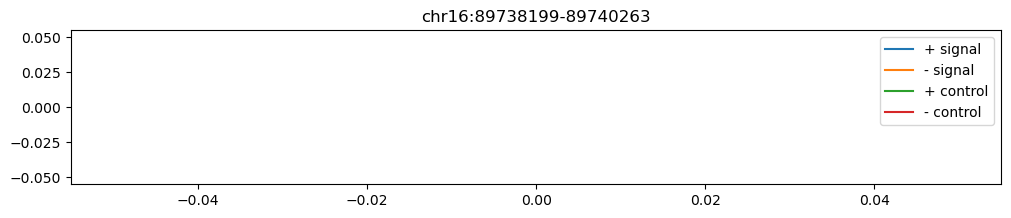

In [162]:
# Plot signal and control
seq_num = 51680
ser = sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
fig, ax = plt.subplots(figsize=(12,2))
plt.plot(sdata["signal"][seq_num][0].values, label="+ signal")
plt.plot(sdata["signal"][seq_num][1].values, label="- signal")
plt.plot(sdata["control"][seq_num][0].values, label="+ control")
plt.plot(sdata["control"][seq_num][1].values, label="- control")
plt.title(ser["chrom"] + ":" + ser["chromStart"].astype(str) + "-" + ser["chromEnd"].astype(str))
plt.legend()
np.isnan(sdata["signal"][seq_num].values[0]).all()

In [17]:
import pyBigWig

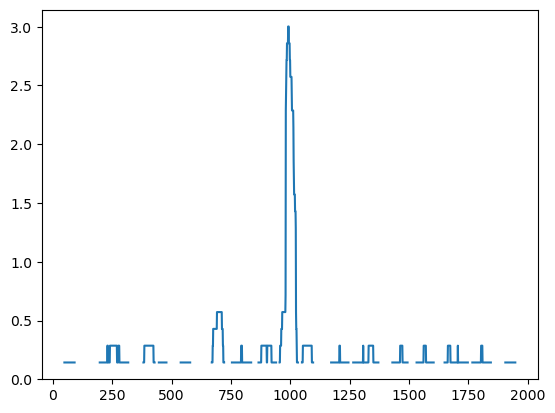

In [18]:
file = pyBigWig.open(str(signals[0]))
contig = ser["chrom"]
start = ser["chromStart"]
end = ser["chromEnd"]
vals = np.array(file.values(contig, start, end))
vals[vals == np.nan] = 0
plt.plot(vals, label="+ signal")

  0%|          | 0/1 [00:00<?, ?it/s]

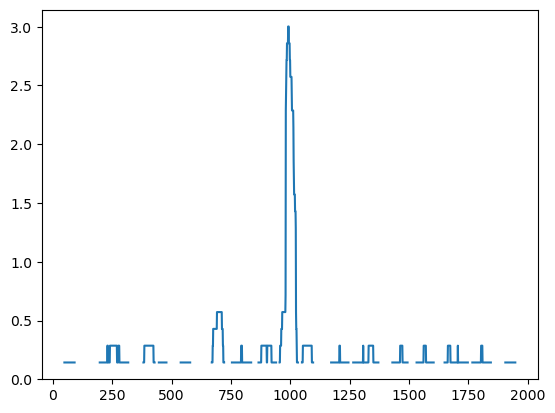

In [19]:
bw_reader = sd.BigWig(
    'test_cov',
    bigwigs[0],
    sample_names[0],
    batch_size=2048,
    n_jobs=4,
    threads_per_job=2,
    dtype="float32",
)
bed = ser.to_frame().T.drop("name", axis=1)
gen = bw_reader._reader(
    bed,
    file,
    file.chroms()
)
plt.plot(next(gen), label="+ signal")

In [20]:
from typing import cast
from numpy.typing import NDArray

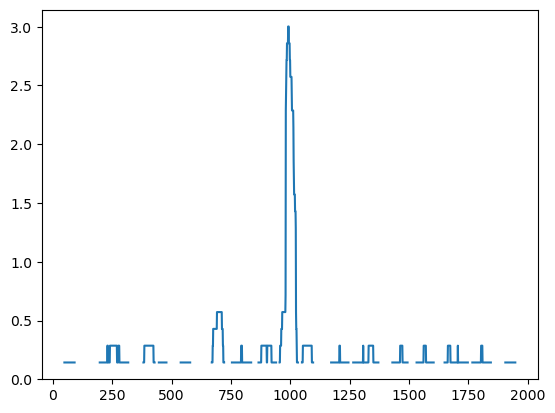

In [21]:
values = cast(
    NDArray,
    file.values(
        contig, max(0, start), min(100000000, end), numpy=True
    ),
)
values = values.astype(np.dtype(np.float64))
values[values == np.nan] = 0
plt.plot(values, label="+ signal")

In [7]:
import pygenometracks.tracks as pygtk
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

import os as _os
import sys as _sys
try:
    _bin_dir = _os.path.dirname(_sys.executable)
    _os.environ["PATH"] += _os.pathsep + _bin_dir
    from pybedtools import paths as _paths
    _paths._set_bedtools_path(_bin_dir)
except ImportError:
    raise ImportError(
        "Please install pybedtools (pip install pybedtools)"
    )

In [8]:
# Region to plot
extension = 0
chrom, start, end = 'chr16', 89738949 , 89739513

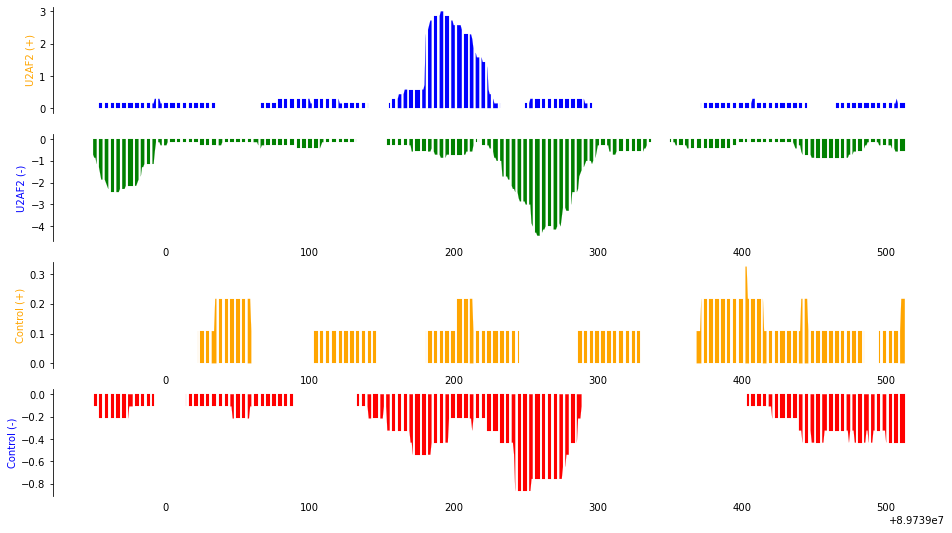

In [9]:
fig, ax = plt.subplots(4, 1, figsize=(16, 9), sharex=True, sharey=False)
config = dict(file=str(signals[0]), region=[(chrom, start, end)], color="blue")
track = pygtk.BigWigTrack(config)
track.plot(ax[0], chrom, start, end)
ax[0].set_ylabel("U2AF2 (+)", color="orange")
ax[0].set_xlabel("")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[0].xticklabels = []

config = dict(file=str(signals[1]), region=[(chrom, start, end)], color="green")
track = pygtk.BigWigTrack(config)
track.plot(ax[1], chrom, start, end)
ax[1].set_ylabel("U2AF2 (-)", color="blue")
ax[1].set_xlabel("")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
ax[1].xticklabels = []

config = dict(file=str(controls[0]), region=[(chrom, start, end)], color="orange")
track = pygtk.BigWigTrack(config)
track.plot(ax[2], chrom, start, end)
ax[2].set_ylabel("Control (+)", color="orange")
ax[2].set_xlabel("")
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
ax[2].xticklabels = []

config = dict(file=str(controls[1]), region=[(chrom, start, end)], color="red")
track = pygtk.BigWigTrack(config)
track.plot(ax[3], chrom, start, end)
ax[3].set_ylabel("Control (-)", color="blue")
ax[3].set_xlabel("")
ax[3].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
ax[3].xticklabels = []

In [43]:
pp.train_test_chrom_split(sdata, test_chroms=["chr1", "chr8", "chr15"], train_var="train_test")
pp.train_test_chrom_split(sdata, test_chroms=["chr2", "chr9", "chr16"], train_var="train_val")

In [44]:
train_sdata = sdata.sel(_sequence=(sdata["train_val"] & sdata["train_test"]))
valid_sdata = sdata.sel(_sequence=~sdata["train_val"])
test_sdata = sdata.sel(_sequence=~sdata["train_test"])

In [45]:
train_sdata.dims["_sequence"], valid_sdata.dims["_sequence"], test_sdata.dims["_sequence"]

(40890, 14178, 7976)

# Instantiate model

In [46]:
import torch
import numpy as np
from bpnetlite import BPNet

In [47]:
# Create the model, we need 2 channels for the control tracks, 2 channels for the signal tracks, and to trim to 1000 bp of input
model = BPNet(n_outputs=2, n_control_tracks=2, trimming=100)

# Training data

In [48]:
import seqpro as sp

In [49]:
# Define training transformations
from eugene.dataload._augment import RandomRC

def seq_trans(x):
    x = np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return x

def cov_dtype(x):
    return tuple(arr.astype('f4') for arr in x)

def jitter(x):
    return sp.jitter(*x, max_jitter=32, length_axis=-1, jitter_axes=0)

def to_tensor(x):
    return tuple(torch.tensor(arr, dtype=torch.float32) for arr in x)

def random_rc(x):
    return RandomRC(rc_prob=0.5)(*x)

# Get the train dataloader
train_dl = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=['_sequence'],
    variables=['seq', 'control', 'signal'],
    prefetch_factor=None,
    batch_size=32,
    transforms={
        ('seq', 'control', 'signal'): jitter,
        'seq': seq_trans,
        'signal': lambda x: x[..., 100:-100],
        ('control', 'signal'): cov_dtype,
        ('control', 'seq', 'signal'): to_tensor,
        ('signal', 'control', 'seq'): random_rc
    },
    return_tuples=True,
    shuffle=True,
)

In [50]:
# Test out a prediction batch
batch = next(iter(train_dl))
pred_ctl = model.forward(*batch[:2])
batch[0].shape, batch[1].shape, batch[2].shape, pred_ctl[0].shape, pred_ctl[1].shape

(torch.Size([32, 4, 500]),
 torch.Size([32, 2, 500]),
 torch.Size([32, 2, 300]),
 torch.Size([32, 2, 300]),
 torch.Size([32, 1]))

# Validation data

In [51]:
# Get the validation data
def seq_trans(x):
    x = x[..., 32:-32]
    np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return torch.as_tensor(x.astype('f4'))

def ctl_trans(x):
    x = x[..., 32:-32]
    return torch.as_tensor(x.astype('f4'))

def cov_trans(x):
    x = x[..., 32+100:-32-100]
    return torch.as_tensor(x.astype('f4'))

X_valid = seq_trans(valid_sdata["seq"].values)
X_ctl_valid = ctl_trans(valid_sdata["control"].values)
y_valid = cov_trans(valid_sdata["signal"].values)
X_valid.shape, X_ctl_valid.shape, y_valid.shape

(torch.Size([14178, 4, 500]),
 torch.Size([14178, 2, 500]),
 torch.Size([14178, 2, 300]))

In [53]:
# Test out a prediction batch
pred_ctl = model.forward(X=X_valid[:128], X_ctl=X_ctl_valid[:128])
pred_ctl[0].shape, pred_ctl[1].shape

(torch.Size([128, 2, 300]), torch.Size([128, 1]))

# Training

In [54]:
# Send the model to the GPU
model.cuda()

BPNet(
  (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(66, 2, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=65, out_features=1, bias=True)
)

In [55]:
# Quickly define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Use the models fit_generator method to train the model
res = model.fit(
    train_dl,
    optimizer,
    X_valid=X_valid,
    X_ctl_valid=X_ctl_valid,
    y_valid=y_valid,
    max_epochs=50,
    batch_size=128,
    early_stopping=10
)

Epoch	Iteration	Training Time	Validation Time	Training MNLL	Training Count MSE	Validation MNLL	Validation Profile Pearson	Validation Count Pearson	Validation Count MSE	Saved?
0	0	2.3746	0.5532	1160.7222	27.8777	229879.5156	-0.012643219	-0.18675092	13.3944	True
0	100	3.4461	0.431	607.5889	26.0638	240012.7969	0.124300875	-0.1571075	12.5791	False
0	200	3.2612	0.4132	493.2613	20.8513	234491.0	0.27317148	0.19048934	10.5214	False
0	300	3.2849	0.4533	411.7409	6.5613	880112.875	0.2765224	0.16013545	7.1906	False
0	400	3.335	0.4351	437.8343	9.9305	287232.3125	0.24513292	0.19129437	7.3861	False
0	500	3.6872	0.4397	281.9176	6.6247	1679219.125	0.28449664	0.18660541	7.2549	False
0	600	3.5012	0.44	574.0652	3.0818	449330.5	0.2878562	0.19039442	8.5202	False
0	700	3.3901	0.4436	2367.7051	1.5017	283723.5938	0.2970449	0.1918029	10.8368	False
0	800	4.6254	0.4576	270.8389	1.2235	682598.1875	0.32785782	0.18716763	10.6724	False
0	900	3.6481	0.4371	5567.3218	18.616	318607.1562	0.020352028	0.056073993	49.6185	F

# DONE!

----